In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Makine Öğrenmesi Kütüphaneleri
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

# Metrikler (Başarı Ölçümü)
from sklearn.metrics import (
    accuracy_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    confusion_matrix,
    classification_report
)

import warnings

# Gereksiz uyarıları kapatalım (Temiz görüntü için)
warnings.filterwarnings('ignore')

# Görselleştirme Ayarları
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# --- VERİ YÜKLEME ---
file_path = '/content/male_players.csv'

# Dosyayı okuyoruz
print("⏳ Veri seti yükleniyor...")
df = pd.read_csv(file_path, low_memory=False)
print(f"✅ Ham Veri Yüklendi. İlk Boyut: {df.shape}")

⏳ Veri seti yükleniyor...
✅ Ham Veri Yüklendi. İlk Boyut: (180021, 109)


In [8]:

if 'fifa_version' in df.columns:
    print("🎯 Sadece FIFA 24 (fifa_version == 24.0) seçiliyor...")

    # 1. Sadece 24 olanları al
    df = df[df['fifa_version'] == 24.0].copy()

    # 2. SIRALAMA
    # Önce en güçlüleri en tepeye alıyoruz.
    # Böylece aynı isimden 2 tane varsa, en iyi versiyonu (main) yukarıda kalır.
    df = df.sort_values(by='overall', ascending=False)

    # 3. İSME GÖRE KOPYALARI SİL
    # 'player_id' işe yaramadığı için 'short_name' kullanıyoruz.
    # keep='first' komutu, yukarıdaki sıralama sayesinde en yüksek reytingliyi tutar.
    df = df.drop_duplicates(subset=['short_name'], keep='first')

    # İndeksleri sıfırla
    df = df.reset_index(drop=True)

    print(f"✅ İşlem Tamam! İsim benzerliği olan kopyalar temizlendi.")
    print(f"👥 Son Oyuncu Sayısı: {len(df)}")

else:
    print("⚠️ HATA: 'fifa_version' sütunu bulunamadı!")

🎯 Sadece FIFA 24 (fifa_version == 24.0) seçiliyor...
✅ İşlem Tamam! İsim benzerliği olan kopyalar temizlendi.
👥 Son Oyuncu Sayısı: 17444


In [9]:
# Sütun isimlerini küçük harfe çevir
df.columns = [c.lower() for c in df.columns]

# SÜTUNLARI EKLEME
needed_cols = [
    'short_name',
    'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
    'age', 'movement_reactions', 'skill_ball_control',
    'overall', 'value_eur', 'player_positions'
]
# Sadece mevcut sütunları al
existing_cols = [col for col in needed_cols if col in df.columns]
df_clean = df[existing_cols].copy()

# 1. TEMİZLİK: Eksik verileri (NaN) çıkar.
# NOT: Kalecilerin şut/pas özellikleri boş olduğu için burada otomatik silinirler.
# Bu istediğimiz bir şey, çünkü modelimiz "Saha İçi" oyunculara odaklanacak.
df_clean = df_clean.dropna()

# 2. TEMİZLİK: Değeri 0 olan oyuncuları çıkar
df_clean = df_clean[df_clean['value_eur'] > 0]

# --- POZİSYON AYARLAMASI (MAPPING) ---
# Karmaşık pozisyonlardan ilkini al (Örn: "ST, LW" -> "ST")
df_clean['primary_pos'] = df_clean['player_positions'].apply(lambda x: str(x).split(',')[0].strip())

# Mevkileri 3 ana gruba indirgiyoruz (Kaleci YOK)
pos_map = {
    'ST': 'Forvet', 'CF': 'Forvet', 'LW': 'Forvet', 'RW': 'Forvet',
    'CAM': 'Orta Saha', 'CM': 'Orta Saha', 'CDM': 'Orta Saha', 'LM': 'Orta Saha', 'RM': 'Orta Saha',
    'CB': 'Defans', 'LB': 'Defans', 'RB': 'Defans', 'LWB': 'Defans', 'RWB': 'Defans'
}

# Yeni 'Mevki' sütununu oluştur
df_clean['Mevki'] = df_clean['primary_pos'].map(pos_map)

# Eşleşmeyen pozisyonları temizle
df_clean = df_clean.dropna(subset=['Mevki'])

print(f"✅ Veri Temizlendi ve Hazır!")
print(f"Analiz edilecek (Saha İçi) oyuncu sayısı: {len(df_clean)}")
print("Kullanılan Özellikler:", existing_cols)

✅ Veri Temizlendi ve Hazır!
Analiz edilecek (Saha İçi) oyuncu sayısı: 15414
Kullanılan Özellikler: ['short_name', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'age', 'movement_reactions', 'skill_ball_control', 'overall', 'value_eur', 'player_positions']


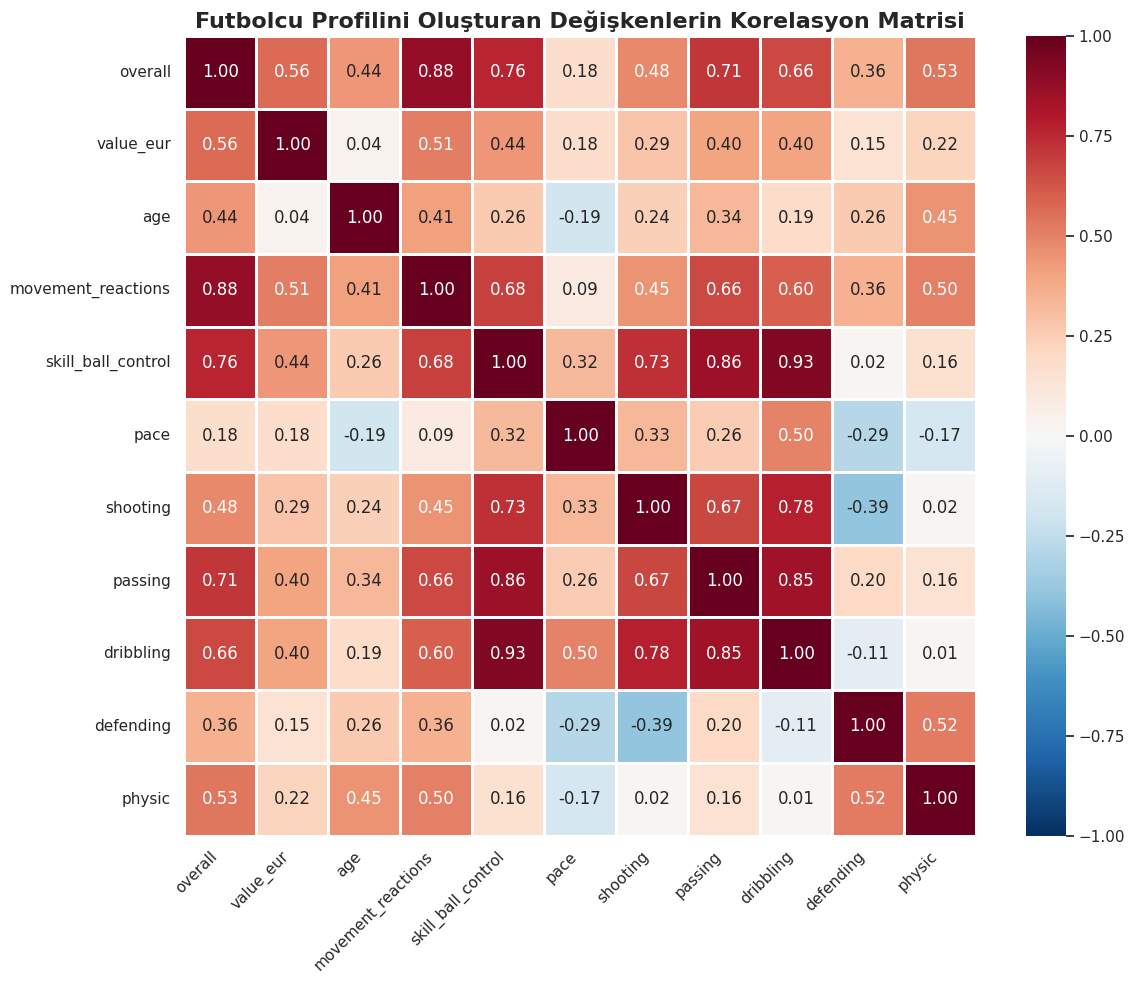

📊 YORUM: Koyu kırmızı kutular, özellikleri birbirine bağlayan en güçlü halkalardır.
Özellikle 'movement_reactions' ve 'value_eur' arasındaki ilişkiye dikkat et!


In [10]:
plt.figure(figsize=(12, 10))

# Analiz edilecek sütunlar
corr_cols = [
    'overall', 'value_eur',
    'age', 'movement_reactions', 'skill_ball_control',
    'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic'
]

# Korelasyonu hesapla
# df_clean artık sadece saha içi oyuncuları içerdiği için sonuçlar çok daha net çıkacak.
corr_matrix = df_clean[corr_cols].corr()

# Isı Haritası
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', fmt=".2f", linewidths=1, vmin=-1, vmax=1)
plt.title('Futbolcu Profilini Oluşturan Değişkenlerin Korelasyon Matrisi', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("📊 YORUM: Koyu kırmızı kutular, özellikleri birbirine bağlayan en güçlü halkalardır.")
print("Özellikle 'movement_reactions' ve 'value_eur' arasındaki ilişkiye dikkat et!")

In [11]:
# 1. GİRDİLERİ (X) HAZIRLA
# KNN'in 'akıllı' tahmin yapması için fiziksel + zihinsel özellikleri alıyoruz.
features = [
    'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
    'age', 'movement_reactions', 'skill_ball_control'
]

# Güvenlik Kontrolü: Listede olup veride olmayan sütun varsa çıkar
features = [col for col in features if col in df_clean.columns]

# X matrisini oluştur
X = df_clean[features].values

# 2. HEDEFLERİ (Y) HAZIRLA
y_pos = df_clean['Mevki'].values       # Sınıflandırma Hedefi (Forvet, Defans vs.)
y_ovr = df_clean['overall'].values     # Regresyon Hedefi 1 (Güç)

# Logaritma Dönüşümü
# 100 Milyon € ile 1 Milyon € arasındaki uçurumu kapatmak için Logaritma alıyoruz.
# Model tahmin edince bunu geri (Exp) çevireceğiz.
y_val = np.log1p(df_clean['value_eur'].values)

# 3. VERİYİ BÖLME (TRAIN - TEST)
# random_state=42 sayesinde her çalıştırmada aynı oyuncular aynı gruba düşer.
X_train, X_test, y_pos_train, y_pos_test, y_ovr_train, y_ovr_test, y_val_train, y_val_test, names_train, names_test = train_test_split(
    X, y_pos, y_ovr, y_val, df_clean['short_name'], test_size=0.2, random_state=42
)

# 4. ÖLÇEKLEME (STANDARD SCALER)
# KNN mesafe ölçer. "Yaş (20)" ile "Dripling (90)" arasındaki sayı farkı kafasını karıştırmasın.
scaler = StandardScaler()

# Sadece TRAIN verisinden öğren (Fit) ve Dönüştür
X_train = scaler.fit_transform(X_train)

# Test verisini, Train'den öğrendiğin kurallarla dönüştür (Sadece Transform)
# ASLA Test verisine 'fit' yapma (Overfitting olur)
X_test = scaler.transform(X_test)

print(f"✅ Hazırlık Tamam!")
print(f"Eğitim Seti: {X_train.shape[0]} oyuncu")
print(f"Test Seti:   {X_test.shape[0]} oyuncu")
print(f"Kullanılan Özellik Sayısı: {X_train.shape[1]}")

✅ Hazırlık Tamam!
Eğitim Seti: 12331 oyuncu
Test Seti:   3083 oyuncu
Kullanılan Özellik Sayısı: 9


 Modeller için en uygun K değerleri aranıyor (1-30 arası)...
NOT: 'Distance' ağırlıklandırması kullanılıyor (Yakın komşunun oyu daha değerli).


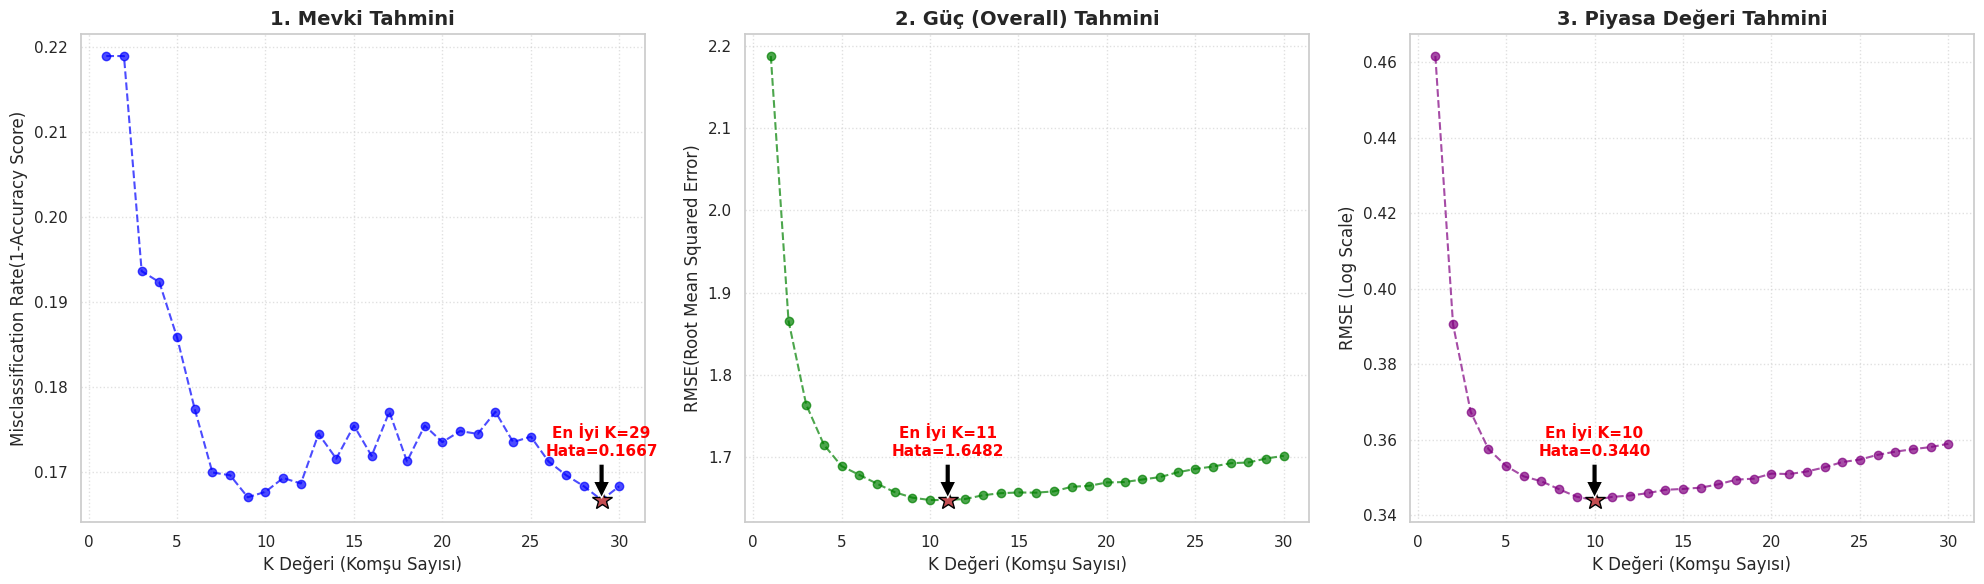

🏆 ANALİZ SONUCU EN İYİ DEĞERLER:
• Mevki Tahmini için ideal K: 29
• Güç Tahmini için ideal K:   11
• Değer Tahmini için ideal K: 10


In [12]:
# ELBOW METHOD (K DEĞERİ OPTİMİZASYONU)
print(" Modeller için en uygun K değerleri aranıyor (1-30 arası)...")
print("NOT: 'Distance' ağırlıklandırması kullanılıyor (Yakın komşunun oyu daha değerli).")

k_range = range(1, 31)

error_class = []  # Model 1 (Mevki) Hataları
rmse_ovr = []     # Model 2 (Güç) Hataları
rmse_val = []     # Model 3 (Değer) Hataları

for k in k_range:
    # 1. Sınıflandırma (Mevki)
    # weights='distance': Yakın komşulara öncelik verir
    knn_c = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn_c.fit(X_train, y_pos_train)
    error_class.append(1 - accuracy_score(y_pos_test, knn_c.predict(X_test)))

    # 2. Regresyon (Overall)
    knn_r1 = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn_r1.fit(X_train, y_ovr_train)
    rmse_ovr.append(np.sqrt(mean_squared_error(y_ovr_test, knn_r1.predict(X_test))))

    # 3. Regresyon (Value)
    knn_r2 = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn_r2.fit(X_train, y_val_train)
    rmse_val.append(np.sqrt(mean_squared_error(y_val_test, knn_r2.predict(X_test))))

# --- GÖRSELLEŞTİRME ---
plt.figure(figsize=(20, 6))

# Fonksiyon: En iyi noktayı bulup grafiğe basan yardımcı kod
def plot_elbow(ax, x_range, y_data, title, y_label, color):
    ax.plot(x_range, y_data, marker='o', color=color, linestyle='--', alpha=0.7)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('K Değeri (Komşu Sayısı)')
    ax.set_ylabel(y_label)
    ax.grid(True, linestyle=':', alpha=0.6)

    # En iyi K değerini bul
    min_err = min(y_data)
    best_k = x_range[y_data.index(min_err)]

    # İşaretle
    ax.plot(best_k, min_err, 'r*', markersize=15, markeredgecolor='black')
    ax.annotate(f'En İyi K={best_k}\nHata={min_err:.4f}',
                 xy=(best_k, min_err), xytext=(best_k, min_err + (max(y_data)-min_err)*0.1),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=11, fontweight='bold', color='red', ha='center')
    return best_k

# Grafik 1: Sınıflandırma
ax1 = plt.subplot(1, 3, 1)
best_k_pos = plot_elbow(ax1, k_range, error_class, '1. Mevki Tahmini', 'Misclassification Rate(1-Accuracy Score)', 'blue')

# Grafik 2: Overall Tahmini
ax2 = plt.subplot(1, 3, 2)
best_k_ovr = plot_elbow(ax2, k_range, rmse_ovr, '2. Güç (Overall) Tahmini', 'RMSE(Root Mean Squared Error)', 'green')

# Grafik 3: Value Tahmini
ax3 = plt.subplot(1, 3, 3)
# BURASI ÖNEMLİ: Etiketi düzelttik. Artık Euro değil, Logaritmik Hata.
best_k_val = plot_elbow(ax3, k_range, rmse_val, '3. Piyasa Değeri Tahmini', 'RMSE (Log Scale)', 'purple')

plt.tight_layout()
plt.show()

print(f"🏆 ANALİZ SONUCU EN İYİ DEĞERLER:")
print(f"• Mevki Tahmini için ideal K: {best_k_pos}")
print(f"• Güç Tahmini için ideal K:   {best_k_ovr}")
print(f"• Değer Tahmini için ideal K: {best_k_val}")

In [13]:
best_k_pos = 29  # Mevki için bulduğumuz değer
best_k_ovr = 11  # Güç için bulduğumuz değer
best_k_val = 10  # Değer için bulduğumuz değer

print("\n" + "="*50)
print(f"🏆 FİNAL MODELLER EĞİTİLİYOR (K Değerleri: {best_k_pos}, {best_k_ovr}, {best_k_val})...")
print("="*50)

# --- MODEL 1: MEVKİ TAHMİNİ (SINIFLANDIRMA) ---
knn_final_pos = KNeighborsClassifier(n_neighbors=best_k_pos, weights='distance')
knn_final_pos.fit(X_train, y_pos_train)
y_pred_pos = knn_final_pos.predict(X_test)

acc = accuracy_score(y_pos_test, y_pred_pos)
print(f"\n✅ 1. MEVKİ TAHMİNİ (K={best_k_pos})")
print(f"   • Başarı Oranı (Accuracy): %{acc*100:.2f}")

# --- MODEL 2: GÜÇ (OVERALL) TAHMİNİ ---
knn_final_ovr = KNeighborsRegressor(n_neighbors=best_k_ovr, weights='distance')
knn_final_ovr.fit(X_train, y_ovr_train)
y_pred_ovr = knn_final_ovr.predict(X_test)

r2_ovr = r2_score(y_ovr_test, y_pred_ovr)
rmse_ovr_score = np.sqrt(mean_squared_error(y_ovr_test, y_pred_ovr))
mae_ovr_score = mean_absolute_error(y_ovr_test, y_pred_ovr)
print(f"\n✅ 2. GÜÇ (OVERALL) TAHMİNİ (K={best_k_ovr})")
print(f"   • R2 Skoru (Başarı): %{r2_ovr*100:.2f}")
print(f"   • Ortalama Hata: +/- {rmse_ovr_score:.2f} Puan")

# --- MODEL 3: DEĞER (VALUE) TAHMİNİ ---
knn_final_val = KNeighborsRegressor(n_neighbors=best_k_val, weights='distance')
knn_final_val.fit(X_train, y_val_train)
y_pred_val_log = knn_final_val.predict(X_test)

# Logaritmik dönüşümü geri al (Normal Para)
y_val_test_euro = np.expm1(y_val_test)
y_pred_val_euro = np.expm1(y_pred_val_log)

r2_val = r2_score(y_val_test_euro, y_pred_val_euro)
rmse_val_euro = np.sqrt(mean_squared_error(y_val_test_euro, y_pred_val_euro)) / 1_000_000

print(f"\n✅ 3. PİYASA DEĞERİ TAHMİNİ (K={best_k_val})")
print(f"   • R2 Skoru (Başarı): %{r2_val*100:.2f}")
print(f"   • Ortalama Hata: +/- {rmse_val_euro:.2f} Milyon €")



🏆 FİNAL MODELLER EĞİTİLİYOR (K Değerleri: 29, 11, 10)...

✅ 1. MEVKİ TAHMİNİ (K=29)
   • Başarı Oranı (Accuracy): %83.33

✅ 2. GÜÇ (OVERALL) TAHMİNİ (K=11)
   • R2 Skoru (Başarı): %93.96
   • Ortalama Hata: +/- 1.65 Puan

✅ 3. PİYASA DEĞERİ TAHMİNİ (K=10)
   • R2 Skoru (Başarı): %83.06
   • Ortalama Hata: +/- 3.34 Milyon €


Görselleştirme Sırası: ['Forvet', 'Orta Saha', 'Defans']


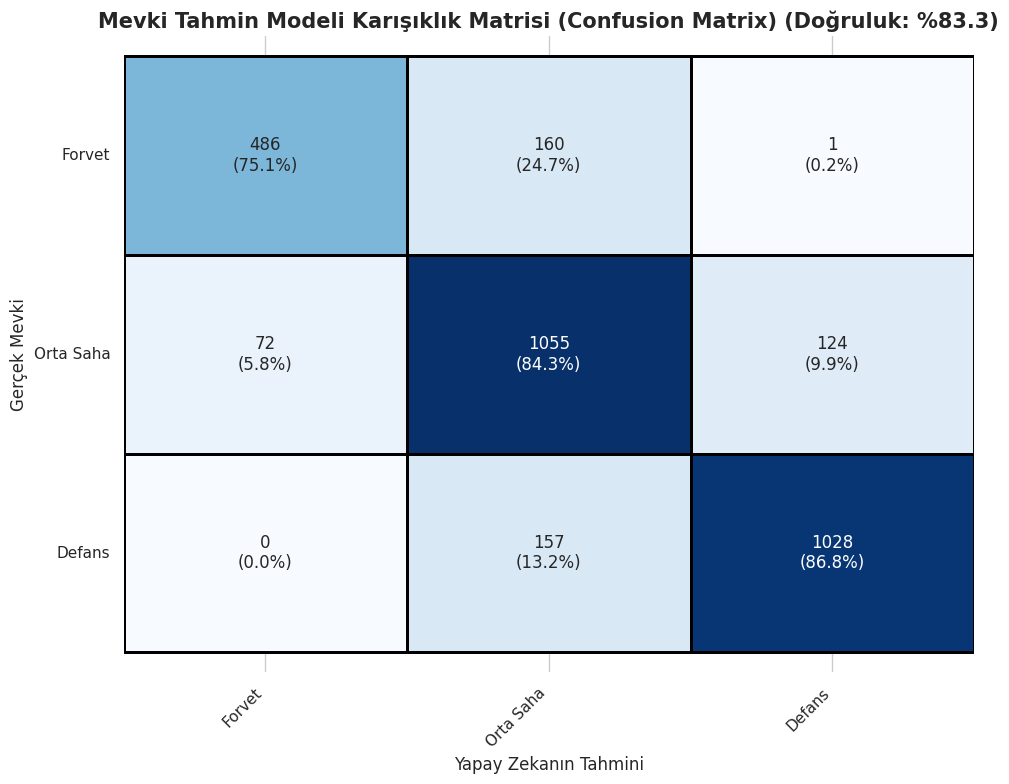


📋 MODEL ANALİZ RAPORU (Özel Sıralı):
              precision    recall  f1-score   support

      Forvet       0.87      0.75      0.81       647
   Orta Saha       0.77      0.84      0.80      1251
      Defans       0.89      0.87      0.88      1185

    accuracy                           0.83      3083
   macro avg       0.84      0.82      0.83      3083
weighted avg       0.84      0.83      0.83      3083



In [14]:
from sklearn.metrics import classification_report

# Bilgisayarın alfabetik sırasını değil, bu mantıklı sırayı kullanacağız.
# NOT: Bu isimlerin veri setindeki ile birebir aynı olması lazım (Büyük/küçük harf dahil).
istenilen_sira = ['Forvet', 'Orta Saha', 'Defans']
print(f"Görselleştirme Sırası: {istenilen_sira}")

# 2. Matrisi BU SIRAYA GÖRE hesapla (labels parametresi ile zorluyoruz)
cm = confusion_matrix(y_pos_test, y_pred_pos, labels=istenilen_sira)

# Yüzdelik Hesaplama
with np.errstate(divide='ignore', invalid='ignore'):
    cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_perc = np.nan_to_num(cm_perc)

# Görselleştirme
plt.figure(figsize=(10, 8))

# Etiketler (Sayı + Yüzde)
annot_labels = [f"{value}\n({perc:.1%})" for value, perc in zip(cm.flatten(), cm_perc.flatten())]
annot_labels = np.asarray(annot_labels).reshape(cm.shape)

# Heatmap Çizimi
# xticklabels ve yticklabels kısmına kendi sıramızı veriyoruz
sns.heatmap(cm, annot=annot_labels, fmt='', cmap='Blues',
            xticklabels=istenilen_sira, yticklabels=istenilen_sira,
            linewidths=1, linecolor='black', cbar=False)

plt.title(f'Mevki Tahmin Modeli Karışıklık Matrisi (Confusion Matrix) (Doğruluk: %{acc*100:.1f})', fontsize=15, fontweight='bold')
plt.xlabel('Yapay Zekanın Tahmini', fontsize=12)
plt.ylabel('Gerçek Mevki', fontsize=12)

# Eksen ayarları
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)
# Sınırları listemizin uzunluğuna göre ayarla
plt.ylim(len(istenilen_sira) + 0.1, -0.1)
plt.tight_layout()

plt.show()

print("\n📋 MODEL ANALİZ RAPORU (Özel Sıralı):")
print(classification_report(y_pos_test, y_pred_pos, labels=istenilen_sira))

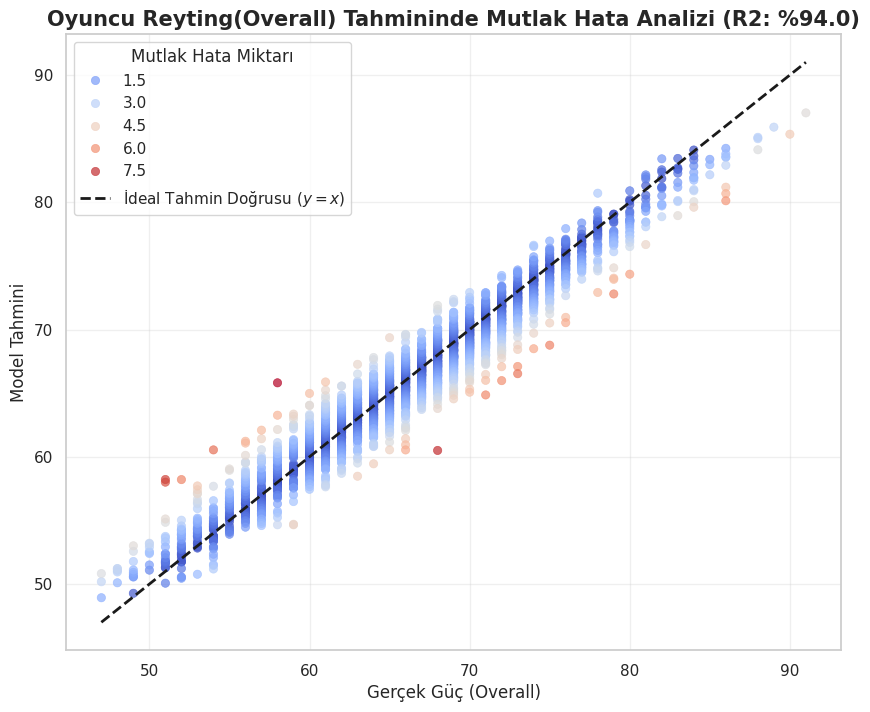

✅ Ortalama Mutlak Hata (MAE): +/- 1.27 Puan
📊 RMSE (Hata Standart Sapması): 1.65 Puan
ℹ️ Mavi noktalar tam isabetleri, kırmızılar ise modelin yanıldığı oyuncuları gösterir.


In [15]:
# 1. Tahminleri Yap (K=11 ile)
# Daha önce eğitmiştik ama emin olmak için tekrar tahmin alalım
y_pred_ovr = knn_final_ovr.predict(X_test)

# 2. Hata Farkını Hesapla (Mutlak Değer)
hata_farki = np.abs(y_ovr_test - y_pred_ovr)

# Görselleştirme DataFrame'i
df_vis_ovr = pd.DataFrame({
    'Gerçek': y_ovr_test,
    'Tahmin': y_pred_ovr,
    'Hata': hata_farki
})

# Hatalı olanlar grafikte üstte görünsün diye sıralıyoruz
df_vis_ovr = df_vis_ovr.sort_values('Hata')

plt.figure(figsize=(10, 8))

# Scatter Plot (Hata payına göre renk değiştirir: Mavi -> Kırmızı)
sns.scatterplot(data=df_vis_ovr, x='Gerçek', y='Tahmin', hue='Hata',
                palette='coolwarm', alpha=0.7, edgecolor=None)

# Referans Çizgisi (Tam İsabet)
plt.plot([min(y_ovr_test), max(y_ovr_test)], [min(y_ovr_test), max(y_ovr_test)],
         'k--', lw=2, label='İdeal Tahmin Doğrusu ($y=x$)')

plt.title(f'Oyuncu Reyting(Overall) Tahmininde Mutlak Hata Analizi (R2: %{r2_ovr*100:.1f})',
          fontsize=15, fontweight='bold')
plt.xlabel('Gerçek Güç (Overall)', fontsize=12)
plt.ylabel('Model Tahmini', fontsize=12)
plt.legend(title='Mutlak Hata Miktarı')
plt.grid(True, alpha=0.3)

plt.show()

print(f"✅ Ortalama Mutlak Hata (MAE): +/- {mae_ovr_score:.2f} Puan")
print(f"📊 RMSE (Hata Standart Sapması): {rmse_ovr_score:.2f} Puan")
print("ℹ️ Mavi noktalar tam isabetleri, kırmızılar ise modelin yanıldığı oyuncuları gösterir.")


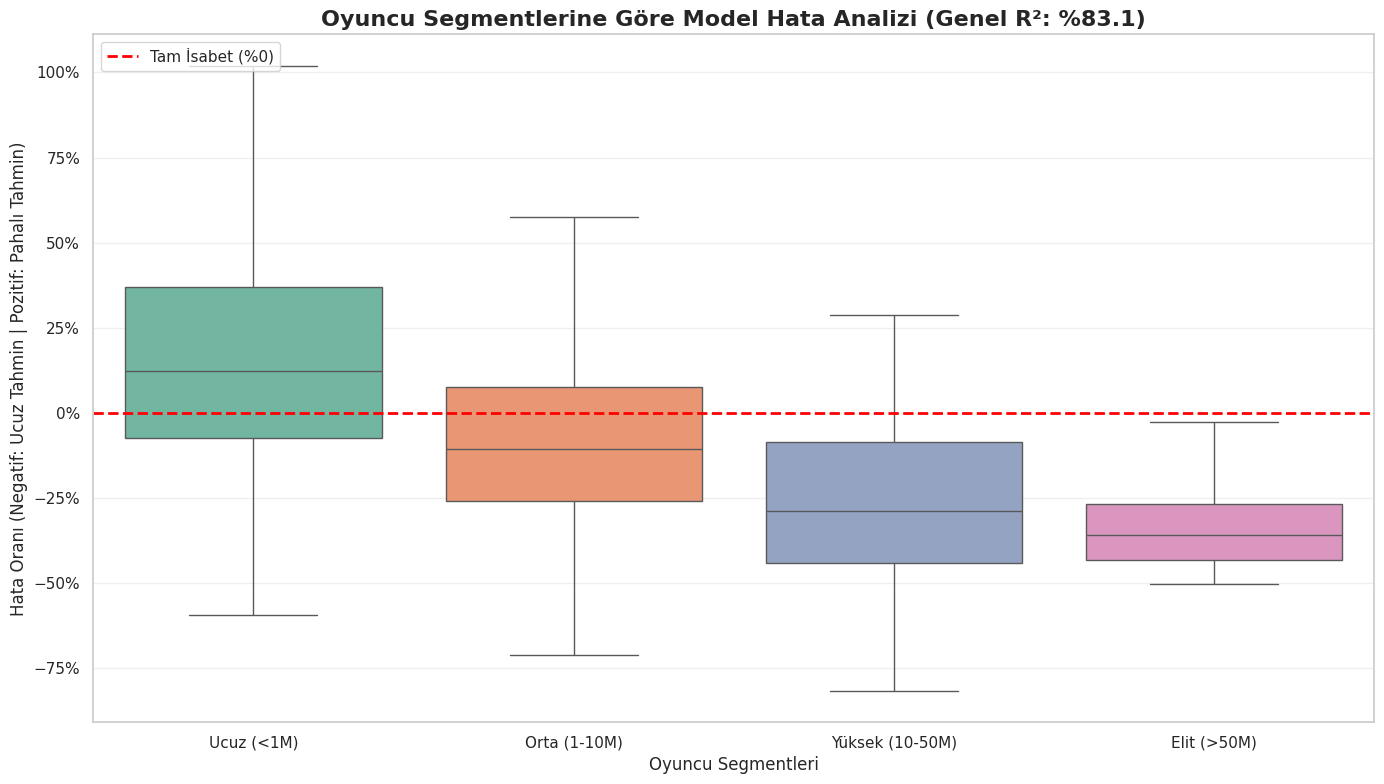

In [20]:
import matplotlib.ticker as ticker
# 1. Veri Hazırlığı
# Logaritmik veriyi (y_val_test) önce Euro'ya, sonra Milyon'a çeviriyoruz.
y_true_m = np.expm1(y_val_test) / 1_000_000        # Gerçek Değer (Milyon €)
y_pred_m = np.expm1(y_pred_val_log) / 1_000_000    # Model Tahmini (Milyon €)

# 2. DataFrame Hazırlığı
df_box = pd.DataFrame({'Gerçek': y_true_m, 'Tahmin': y_pred_m})

# 3. R2 SKORUNU HESAPLIYORUZ (Global Başarı)
genel_r2 = r2_score(df_box['Gerçek'], df_box['Tahmin'])

# 4. Yüzdesel Hata Hesabı: (Tahmin - Gerçek) / Gerçek
df_box['Yuzde_Hata'] = ((df_box['Tahmin'] - df_box['Gerçek']) / df_box['Gerçek']) * 100

# 5. Kategorilere Ayırma
bins = [0, 1, 10, 50, 200]
labels = ['Ucuz (<1M)', 'Orta (1-10M)', 'Yüksek (10-50M)', 'Elit (>50M)']
df_box['Kategori'] = pd.cut(df_box['Gerçek'], bins=bins, labels=labels)

# --- ÇİZİM ---
plt.figure(figsize=(14, 8))

# Kutu Grafiği
ax = sns.boxplot(data=df_box, x='Kategori', y='Yuzde_Hata', palette='Set2', showfliers=False)

# Sıfır Çizgisi (Tam İsabet)
plt.axhline(0, color='red', linestyle='--', linewidth=2, label="Tam İsabet (%0)")

# --- BAŞLIK VE ETİKETLER ---
plt.title(f"Oyuncu Segmentlerine Göre Model Hata Analizi (Genel R²: %{genel_r2*100:.1f})",
          fontsize=16, fontweight='bold')

plt.ylabel("Hata Oranı (Negatif: Ucuz Tahmin | Pozitif: Pahalı Tahmin)", fontsize=12)
plt.xlabel("Oyuncu Segmentleri", fontsize=12)

# Y Eksenini Yüzdeli Yap (%20, %40 gibi)
ax.yaxis.set_major_formatter(ticker.PercentFormatter())

plt.grid(True, axis='y', alpha=0.3)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

old_acc_pos = 83.33
old_r2_ovr = 93.96
old_r2_val = 83.06

print(f"🚀 OPTİMİZASYON BAŞLIYOR... (Hedef: Mevcut skorları geçmek)")
print(f"📊 Mevcut Skorların: Mevki=%{old_acc_pos} | Güç=%{old_r2_ovr} | Değer=%{old_r2_val}")
print("-" * 60)

# Parametreler
param_grid = {
    'n_neighbors': range(5, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# -----------------------------------------------------------------------------
# 1. MEVKİ (POSITION) - EN İYİSİNİ BUL VE TEST ET
# -----------------------------------------------------------------------------
print("\n🔎 1. Mevki Modeli Optimize Ediliyor...")
gs_pos = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gs_pos.fit(X_train, y_pos_train)

# En iyi modeli al ve Test Setinde dene
best_model_pos = gs_pos.best_estimator_
y_pred_new_pos = best_model_pos.predict(X_test)
new_acc_pos = accuracy_score(y_pos_test, y_pred_new_pos) * 100

# -----------------------------------------------------------------------------
# 2. GÜÇ (OVERALL) - EN İYİSİNİ BUL VE TEST ET
# -----------------------------------------------------------------------------
print("🔎 2. Güç (Overall) Modeli Optimize Ediliyor...")
gs_ovr = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2', n_jobs=-1)
gs_ovr.fit(X_train, y_ovr_train)

best_model_ovr = gs_ovr.best_estimator_
y_pred_new_ovr = best_model_ovr.predict(X_test)
new_r2_ovr = r2_score(y_ovr_test, y_pred_new_ovr) * 100

# -----------------------------------------------------------------------------
# 3. DEĞER (VALUE) - EN İYİSİNİ BUL VE TEST ET
# -----------------------------------------------------------------------------
print("🔎 3. Piyasa Değeri Modeli Optimize Ediliyor...")
gs_val = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2', n_jobs=-1)
gs_val.fit(X_train, y_val_train)

best_model_val = gs_val.best_estimator_
y_pred_new_log = best_model_val.predict(X_test)

# Logaritmayı geri çevir (Euro bazında karşılaştırmak için)
y_test_euro = np.expm1(y_val_test)
y_pred_new_euro = np.expm1(y_pred_new_log)
new_r2_val = r2_score(y_test_euro, y_pred_new_euro) * 100

# =============================================================================
# 🏆 BÜYÜK FİNAL: KARŞILAŞTIRMA TABLOSU
# =============================================================================
print("\n" + "="*75)
print(f"{'MODEL':<20} | {'ESKİ SKOR':<12} | {'YENİ SKOR':<12} | {'FARK':<12} | {'EN İYİ AYARLAR'}")
print("="*75)

# Mevki Satırı
diff_pos = new_acc_pos - old_acc_pos
print(f"{'1. Mevki (Acc)':<20} | %{old_acc_pos:<11.2f} | %{new_acc_pos:<11.2f} | {diff_pos:+.2f} {'🔺' if diff_pos>0 else '🔸'} | K={gs_pos.best_params_['n_neighbors']}, {gs_pos.best_params_['weights']}, {gs_pos.best_params_['metric']}")

# Güç Satırı
diff_ovr = new_r2_ovr - old_r2_ovr
print(f"{'2. Güç (R2)':<20} | %{old_r2_ovr:<11.2f} | %{new_r2_ovr:<11.2f} | {diff_ovr:+.2f} {'🔺' if diff_ovr>0 else '🔸'} | K={gs_ovr.best_params_['n_neighbors']}, {gs_ovr.best_params_['weights']}, {gs_ovr.best_params_['metric']}")

# Değer Satırı
diff_val = new_r2_val - old_r2_val
print(f"{'3. Değer (R2)':<20} | %{old_r2_val:<11.2f} | %{new_r2_val:<11.2f} | {diff_val:+.2f} {'🔺' if diff_val>0 else '🔸'} | K={gs_val.best_params_['n_neighbors']}, {gs_val.best_params_['weights']}, {gs_val.best_params_['metric']}")
print("="*75)

print("\n💡 İPUCU: Eğer 'Yeni Skor' daha yüksekse, tablodaki 'En İyi Ayarları' not al.")

🚀 OPTİMİZASYON BAŞLIYOR... (Hedef: Mevcut skorları geçmek)
📊 Mevcut Skorların: Mevki=%83.33 | Güç=%93.96 | Değer=%83.06
------------------------------------------------------------

🔎 1. Mevki Modeli Optimize Ediliyor...
🔎 2. Güç (Overall) Modeli Optimize Ediliyor...
🔎 3. Piyasa Değeri Modeli Optimize Ediliyor...

MODEL                | ESKİ SKOR    | YENİ SKOR    | FARK         | EN İYİ AYARLAR
1. Mevki (Acc)       | %83.33       | %83.17       | -0.16 🔸 | K=28, distance, manhattan
2. Güç (R2)          | %93.96       | %94.55       | +0.59 🔺 | K=15, distance, manhattan
3. Değer (R2)        | %83.06       | %83.56       | +0.50 🔺 | K=11, distance, manhattan

💡 İPUCU: Eğer 'Yeni Skor' daha yüksekse, tablodaki 'En İyi Ayarları' not al.


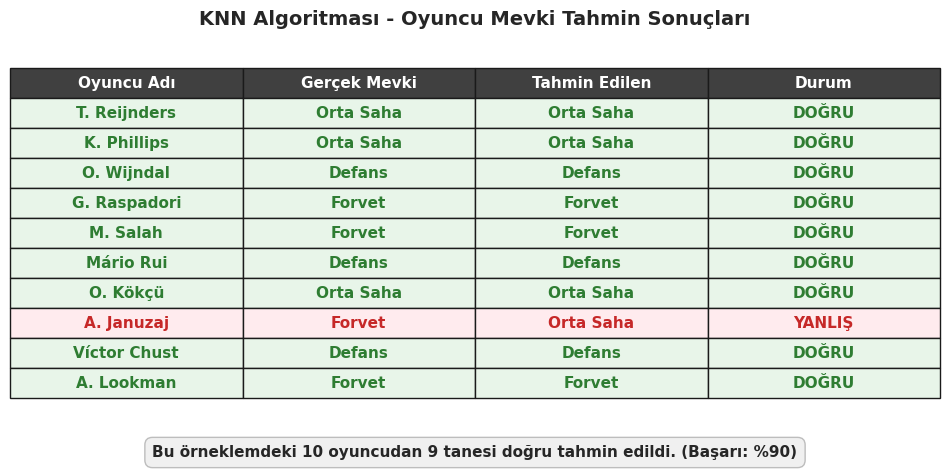

In [ ]:
# Rastgele Oyuncu Mevki Tahmini
# 1. Verileri Hazırla
degerler_euro = np.expm1(y_val_test)

# 2. DataFrame Oluştur
df_tablo = pd.DataFrame({
    'Oyuncu Adı': names_test,
    'Gerçek Mevki': y_pos_test,
    'Tahmin Edilen': y_pred_pos,
    'Piyasa Değeri': degerler_euro # Filtreleme için hala lazım
})

# 3. FİLTRELEME: 10 Milyon Euro üstü (Bilindik oyuncular gelsin)
df_tablo = df_tablo[df_tablo['Piyasa Değeri'] > 10_000_000].copy()

# 4. Rastgele 10 Kişi Seç
n_sample = min(len(df_tablo), 10)
random_tablo = df_tablo.sample(n=n_sample)

# 5. Durum Kontrolü (Yazı Olarak)
def durum_kontrol(row):
    return "DOĞRU" if row['Gerçek Mevki'] == row['Tahmin Edilen'] else "YANLIŞ"

random_tablo['Durum'] = random_tablo.apply(durum_kontrol, axis=1)

# 6. SADELEŞTİRME: Piyasa Değerini Görüntüden Atıyoruz
final_gosterim = random_tablo[['Oyuncu Adı', 'Gerçek Mevki', 'Tahmin Edilen', 'Durum']]

# Başarı Sayısını Hesapla
dogru_sayisi = len(random_tablo[random_tablo['Durum'] == "DOĞRU"])
basari_orani = (dogru_sayisi / n_sample) * 100

#Tablo Çizimi
fig, ax = plt.subplots(figsize=(10, 5))

# Eksenleri Kapat
ax.axis('tight')
ax.axis('off')

# Tabloyu Çiz
table = ax.table(cellText=final_gosterim.values,
                 colLabels=final_gosterim.columns,
                 cellLoc='center',
                 loc='center')

# --- TASARIM AYARLARI ---
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)

# Renklendirme
for (row, col), cell in table.get_celld().items():
    if row == 0:
        # Başlık Satırı
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#404040')
    else:
        # Veri Satırları (Durum sütunu artık 3. indeks oldu: 0,1,2,3)
        durum_metni = final_gosterim.iloc[row-1, 3]

        if durum_metni == "DOĞRU":
            cell.set_facecolor('#e8f5e9') # Yeşilimsi
            cell.set_text_props(color='#2e7d32', weight='bold') # Yazı da yeşil olsun
        else:
            cell.set_facecolor('#ffebee') # Kırmızımsı
            cell.set_text_props(color='#c62828', weight='bold') # Yazı da kırmızı olsun

# Başlık
plt.title("KNN Algoritması - Oyuncu Mevki Tahmin Sonuçları", fontsize=14, fontweight='bold', y=1.02)

# 7. ALT BİLGİ (SKOR) EKLEME
ozet_metin = f"Bu örneklemdeki {n_sample} oyuncudan {dogru_sayisi} tanesi doğru tahmin edildi. (Başarı: %{basari_orani:.0f})"

# Tablonun altına metin ekle (x=0.5 ortalar, y=-0.05 tablonun altı)
plt.text(0.5, -0.05, ozet_metin,
         ha='center', va='top', transform=ax.transAxes,
         fontsize=11, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.5", fc="#f0f0f0", ec="#bdbdbd"))

plt.show()

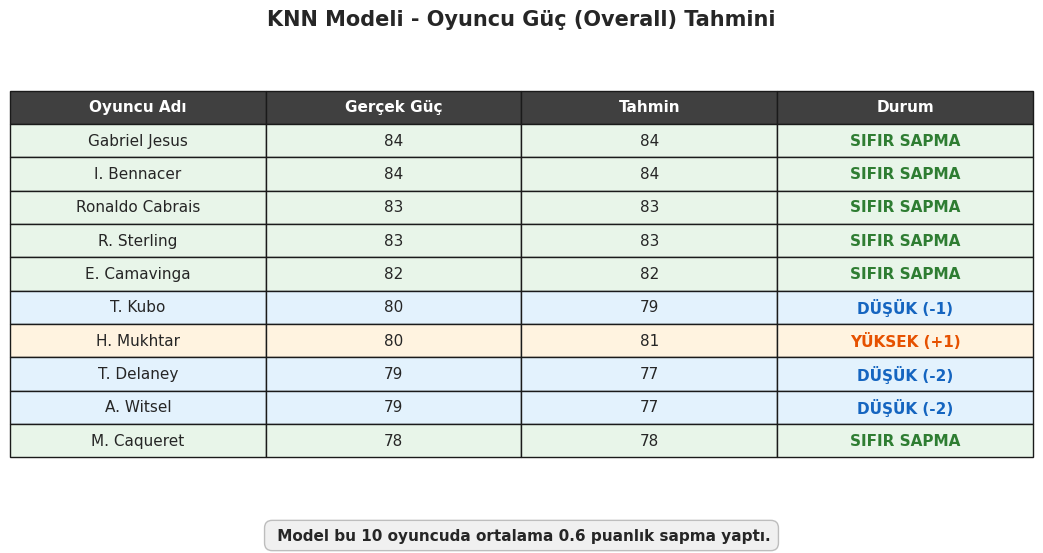

In [ ]:
# Rastgele Oyuncu Overall Tahmini
# 1. DataFrame Oluştur
df_ovr_tablo = pd.DataFrame({
    'Oyuncu Adı': names_test,
    'Gerçek Güç': y_ovr_test,
    'Tahmin': y_pred_ovr
})

# 2. TAHMİNLERİ YUVARLA (88.4 -> 88 olsun ki karşılaştırma net olsun)
df_ovr_tablo['Tahmin'] = df_ovr_tablo['Tahmin'].round(0).astype(int)

# 3. FİLTRELEME: Sadece 78 Reyting ve üzeri (Yıldızlar Ligi)
# Bilindik isimleri görmek için çıtayı biraz yüksek tuttum.
df_ovr_tablo = df_ovr_tablo[df_ovr_tablo['Gerçek Güç'] >= 78].copy()

# 4. RASTGELE 10 OYUNCU SEÇ
n_sample = min(len(df_ovr_tablo), 10)
random_tablo_ovr = df_ovr_tablo.sample(n=n_sample).sort_values(by='Gerçek Güç', ascending=False)

# 5. DURUM ANALİZİ (YÜKSEK / DÜŞÜK / TAM İSABET)
def durum_analizi(row):
    fark = row['Tahmin'] - row['Gerçek Güç']

    if fark == 0:
        return "SIFIR SAPMA"
    elif fark > 0:
        return f"YÜKSEK (+{fark})" # Örn: YÜKSEK (+2)
    else:
        return f"DÜŞÜK ({fark})"   # Örn: DÜŞÜK (-3)

random_tablo_ovr['Durum'] = random_tablo_ovr.apply(durum_analizi, axis=1)

# Tabloda görünecek sütunlar
final_gosterim = random_tablo_ovr[['Oyuncu Adı', 'Gerçek Güç', 'Tahmin', 'Durum']]


# TABLO ÇİZİMİ

fig, ax = plt.subplots(figsize=(11, 6))

# Eksenleri Temizle
ax.axis('tight')
ax.axis('off')

# Tabloyu Çiz
table = ax.table(cellText=final_gosterim.values,
                 colLabels=final_gosterim.columns,
                 cellLoc='center',
                 loc='center')

# --- TASARIM VE RENKLENDİRME ---
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2) # Satır yüksekliği

for (row, col), cell in table.get_celld().items():
    if row == 0:
        # BAŞLIK (Header)
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#404040')
    else:
        # VERİ SATIRLARI
        durum_metni = final_gosterim.iloc[row-1, 3] # Son sütun (Durum)

        # Renk Mantığı 🚥
        if "SIFIR SAPMA" in durum_metni:
            cell.set_facecolor('#e8f5e9') # YEŞİL
            if col == 3: cell.set_text_props(color='#2e7d32', weight='bold')

        elif "YÜKSEK" in durum_metni:
            cell.set_facecolor('#fff3e0') # TURUNCU
            if col == 3: cell.set_text_props(color='#e65100', weight='bold')

        elif "DÜŞÜK" in durum_metni:
            cell.set_facecolor('#e3f2fd') # MAVİ
            if col == 3: cell.set_text_props(color='#1565c0', weight='bold')

# Başlık
plt.title("KNN Modeli - Oyuncu Güç (Overall) Tahmini", fontsize=15, fontweight='bold', y=1.02)

# Alt Bilgi (Hata Özeti)
ortalama_sapma = np.abs(random_tablo_ovr['Tahmin'] - random_tablo_ovr['Gerçek Güç']).mean()
ozet_metin = f" Model bu 10 oyuncuda ortalama {ortalama_sapma:.1f} puanlık sapma yaptı."

plt.text(0.5, -0.05, ozet_metin,
         ha='center', va='top', transform=ax.transAxes,
         fontsize=11, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.5", fc="#f0f0f0", ec="#bdbdbd"))

plt.show()

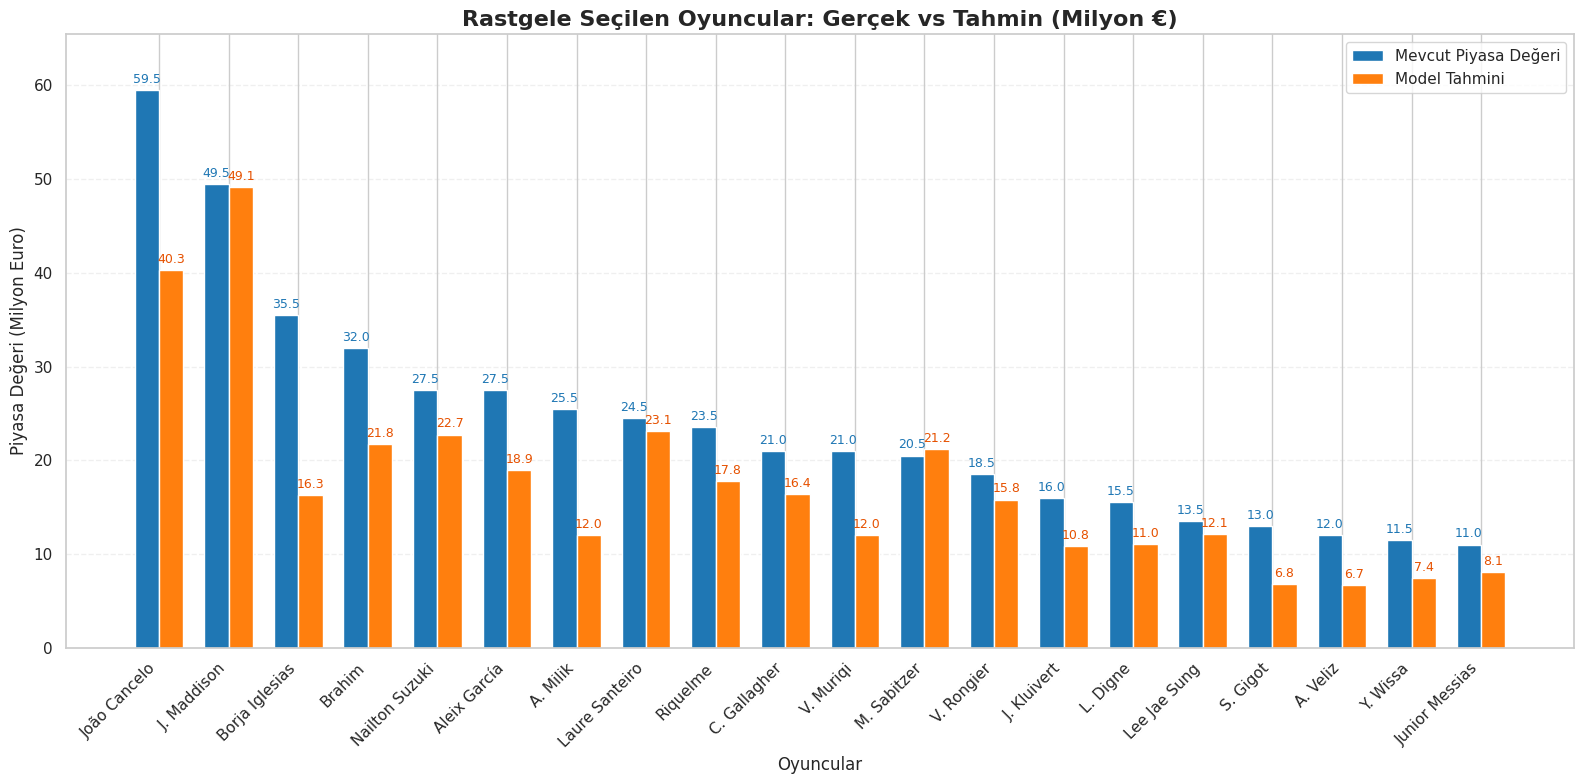

In [ ]:
# Rastgele Oyuncu Piyasa Tahmini
# Önce logaritmik değerleri Euro'ya çevirelim
y_val_test_euro = np.expm1(y_val_test)
y_pred_val_euro = np.expm1(y_pred_val_log)

# Tabloyu oluştur
df_sonuc_val = pd.DataFrame({
    'Oyuncu': names_test.values,
    'Gerçek Değer': y_val_test_euro,
    'Yapay Zeka': y_pred_val_euro
})

# 1. FİLTRELEME (10M - 70M Euro Arası)
filtre = (df_sonuc_val['Gerçek Değer'] >= 10_000_000) & (df_sonuc_val['Gerçek Değer'] <= 70_000_000)
df_filtered = df_sonuc_val[filtre]

# 2. RASTGELE 20 OYUNCU SEÇ
n_sample = min(len(df_filtered), 20)
df_random20 = df_filtered.sample(n=n_sample)

# 3. SIRALAMA
df_random20 = df_random20.sort_values(by='Gerçek Değer', ascending=False)

# 4. MİLYON EURO CİNSİNE ÇEVİRME
df_random20 = df_random20.copy()
df_random20['Gerçek Değer'] = df_random20['Gerçek Değer'] / 1_000_000
df_random20['Yapay Zeka'] = df_random20['Yapay Zeka'] / 1_000_000

# 5. ÇİZİM
plt.figure(figsize=(16, 8))
x = np.arange(len(df_random20))
width = 0.35

# Sütunları değişkenlere atıyoruz (rects1 ve rects2) ki sonra üzerlerine yazı yazabilelim
rects1 = plt.bar(x - width/2, df_random20['Gerçek Değer'], width, label='Mevcut Piyasa Değeri', color='#1f77b4')
rects2 = plt.bar(x + width/2, df_random20['Yapay Zeka'], width, label='Model Tahmini', color='#ff7f0e')

plt.title('Rastgele Seçilen Oyuncular: Gerçek vs Tahmin (Milyon €)', fontsize=16, fontweight='bold')
plt.ylabel('Piyasa Değeri (Milyon Euro)', fontsize=12)
plt.xlabel('Oyuncular', fontsize=12)

plt.xticks(ticks=x, labels=df_random20['Oyuncu'], rotation=45, ha='right', fontsize=11)

# --- 🛠️ EKLEME BURADA: SÜTUN ÜSTÜNE YAZI YAZDIRMA ---
ax = plt.gca() # Mevcut ekseni al

# Mavi Sütunlar için Etiketler
ax.bar_label(rects1, fmt='%.1f', padding=3, fontsize=9, color='#1f77b4')

# Turuncu Sütunlar için Etiketler
ax.bar_label(rects2, fmt='%.1f', padding=3, fontsize=9, color='#e65100')

# Y eksenini biraz yukarı genişletelim ki sayılar grafiğin tavanına çarpmasın
plt.ylim(0, df_random20[['Gerçek Değer', 'Yapay Zeka']].max().max() * 1.1)

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()

plt.show()